In [3]:
import numpy as np
import sympy as sp
import control as ct
from control2020 import core
from matplotlib import pyplot as plt
s = sp.var("s")

In [135]:
# designing a PID controller with root locus method

gs = 1/s/(s+1)/(s+3)
sys = core.symbolic_transfer_function(gs)

# design params
ts = 11.5
po = 0.5

psi, wn = core.from_quality_to_psi_wn(po, ts)
print(f"psi= {psi}\nwn= {wn}")
pds = core.construct_poles(psi, wn)

print(pds)

pd = pds[0] # util pole in the (Re-, Im+) plane

# finding b with the angle condition
poles_angles = []
for pole in [*ct.pole(sys), 0]: # for each pole and added the pole generated for the PID integrator 
    angle = np.angle(pd - pole)*180/np.pi
    if angle < 0:
        angle = 360 + angle
    poles_angles.append(angle)

zeros_angles = []
for zero in ct.zero(sys): # for each pole
    zeros_angles.append(np.angle(pd - zero)*180/np.pi)

print("poles_angles", poles_angles)
print("zeros_angles", zeros_angles)

a_angle = -180 - (sum(zeros_angles) - sum(poles_angles))
a_angle = a_angle/2 # because a == b in the PID controller form

print(a_angle)
dist = pd.imag/np.tan(a_angle*np.pi/180)
b = pd.real - dist # finally, we have b
print(b)

# finding Kc with module condition

poles_dists = []
for pole in [*ct.pole(sys), 0]: # for each pole and added the pole generated for the PID integrator 
    poles_dists.append(np.abs(pd - pole))

zeros_dists = []
for zero in [*ct.zero(sys), b, b]: # for each pole added with our new zeros (from PID) calculated before
    zeros_dists.append(np.abs(pd - zero))
    
k = sys.num[0][0][-1] # assuming the basic form of a SISO system
kc = np.prod(poles_dists)/k/np.prod(zeros_dists)

# defining PID constants
kp = -2*kc*b
ki = kc*b**2
kd = kc

print(kp, ki, kd)

c = kp + kd*s + ki/s
pid = core.symbolic_transfer_function(c)

psi= 0.8601598514412787
wn= 0.40437377584376494
((-0.3478260869565218+0.20624054844442594j), (-0.3478260869565218-0.20624054844442594j))
poles_angles [4.4465335396039025, 17.54880385006681, 149.33453574048792, 149.33453574048792]
zeros_angles []
70.33220443532326
-0.4215401368685592
5.229338891393239 1.1021881160049927 6.202658340246973


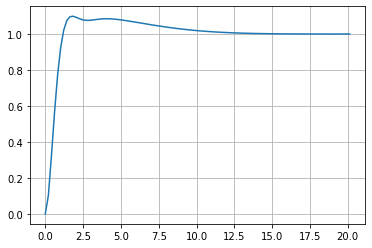

In [136]:
tf = ct.feedback(sys*pid, 1)
t, y = ct.step_response(tf)
plt.plot(t, y)
plt.grid()

In [113]:
ct.damp(tf)

_____Eigenvalue______ Damping___ Frequency_
    -1.501                     1      1.501
   -0.2667    +0.315j     0.6461     0.4127
   -0.2667    -0.315j     0.6461     0.4127


(array([1.50139658, 0.41274411, 0.41274411]),
 array([1.       , 0.6460823, 0.6460823]),
 array([-1.50139658+0.j        , -0.26666667+0.31503427j,
        -0.26666667-0.31503427j]))

In [137]:
ct.step_info(tf)

{'RiseTime': 0.785660660660661,
 'SettlingTime': 9.89126626626627,
 'SettlingMin': 0.9049684998667721,
 'SettlingMax': 1.0986880556700782,
 'Overshoot': 9.912199956010781,
 'Undershoot': 0.0,
 'Peak': 1.0986880556700782,
 'PeakTime': 1.7727727727727733,
 'SteadyStateValue': 0.9996051904245359}

In [45]:
import random

In [47]:
random.random()

0.07374635097620597

In [62]:
sys.num[0][0][-1]

1.0

In [291]:
# Designing compensators
# A Lead Compensator

gs = 10/s/(s+1)

sys = core.symbolic_transfer_function(gs)

po = 16.3
ts = 2.67

psi, wn = core.from_quality_to_psi_wn(po, ts)
print("psi= %.2f | wn= %.2f"%(psi, wn))
print("")
d_poles = core.construct_poles(psi, wn)
print("desired poles")
for d_p in poles:
    print("%.2f + %.2fi"%(d_p.real, d_p.imag))
    
pd = d_poles[0]

poles_angles = []
for pole in sys.pole():
    angle = np.angle(pd - pole)*180/np.pi
    if angle < 0:
        angle = 360 - angle
    poles_angles.append(angle)
    
zeros_angles = []
for zero in sys.zero():
    angle = np.angle(pd - zero)*180/np.pi
    if angle < 0:
        angle = 360 - angle
    zeros_angles.append(angle)

plant_angle = sum(zeros_angles) - sum(poles_angles)

compensator_angle = -180 - plant_angle
print("")
print("compensator angle= %.2f"%compensator_angle)

compensator_zero = -1.1 # fixed value for your compensator 
compensator_zero_angle = np.angle(pd - compensator_zero)*180/np.pi

print("")
print("fixed zero= %.2f | angle= %.2fdeg"%(compensator_zero, compensator_zero_angle))

# angle condition
pole_angle = compensator_zero_angle - compensator_angle # calculated value for your compensator
dist_pole = pd.imag / np.tan(pole_angle*np.pi/180)
print(pole_angle, dist_pole)

compensator_pole = pd.real - dist_pole

print("")
print("calculated pole= %.2f + %.2fi"%(compensator_pole.real, compensator_pole.imag))

# finally we can to calculate the kc of our controller

# module condition
g1 = (s-compensator_zero)/(s-compensator_pole)
g1_sys = core.symbolic_transfer_function(g1)

g1_pd_evaluated = g1_sys.horner(pd)[0][0] # expecting a siso model
sys_pd_evaluated = sys.horner(pd)[0][0] # expecting a siso model

kc = 1/np.abs(g1_pd_evaluated)/np.abs(sys_pd_evaluated)

final_compensator = kc * g1_sys
final_compensator

psi= 0.50 | wn= 3.00

desired poles
-1.50 + 2.59i
-1.50 + -2.59i

compensator angle= 40.87

fixed zero= -1.10 | angle= 98.72deg
57.853061818568065 1.6305143091076781

calculated pole= -3.13 + 0.00i



0.2953 s + 0.3249
-----------------
  0.3196 s + 1

{'RiseTime': 0.5383403612755794,
 'SettlingTime': 2.6731383456442566,
 'SettlingMin': 0.9067884008331618,
 'SettlingMax': 1.1791527734092258,
 'Overshoot': 17.898008414884625,
 'Undershoot': 0.0,
 'Peak': 1.1791527734092258,
 'PeakTime': 1.2004371274420966,
 'SteadyStateValue': 1.0001464734330132}

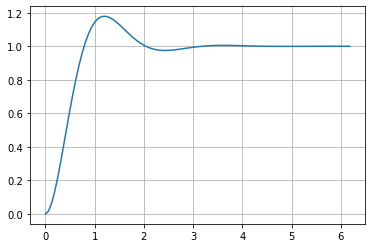

In [210]:
sys_f = ct.feedback(final_compensator*sys, 1)
t, y = ct.step_response(sys_f)
plt.plot(t, y)
plt.grid()
ct.step_info(sys_f)

In [283]:
# Designing compensators
# a Lag Compensator

gs = 1.06*(s+9)/s/(s+1)/(s+2)/(2*s+3.333)

sys = core.symbolic_transfer_function(gs)

# for a lag compensator to set your pole and zero really close to the origin
# for example:
a = -0.05
b = -0.005

lag_compensator = (s-a)/(s-b)
lag_sys = core.symbolic_transfer_function(lag_compensator)

# we use the dominant pole from our closed system
pre_sys = ct.feedback(sys*lag_sys, 1)
pre_sys_poles = ct.pole(pre_sys)
pd = pre_sys_poles[np.argsort(pre_sys_poles)[-2]] # index -1 is our compensator artificial pole

lag_pd_evaluated = lag_sys.horner(pd)[0][0] # expecting a siso model
sys_pd_evaluated = sys.horner(pd)[0][0] # expecting a siso model

kc = 1/np.abs(lag_pd_evaluated)/np.abs(sys_pd_evaluated)

final_compensator = kc * lag_sys

In [280]:
final_compensator


s + 0.05
---------
s + 0.005

In [270]:
kc

0.9999999999999989

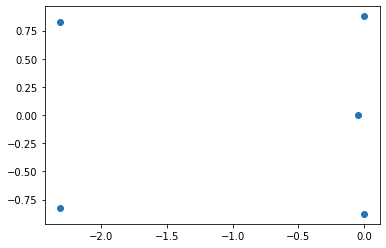

In [274]:
plt.scatter(np.real(pre_sys_poles), np.imag(pre_sys_poles))